<a href="https://www.kaggle.com/code/angevalli/s-p500-forecasting/notebook" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [33]:
from typing import Union, List, Set, Any, Optional

import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import constants as c
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler;

# First approach : Forecast SPY returns with price prediction

## Loadings

Callback useful in the training of LSTM neural network model

In [34]:
# Define Reset States Callback
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [35]:
# Load data from .csv
data: pd.DataFrame = pd.read_csv("data.csv")

# Set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Deactivate Settings Warning
pd.options.mode.chained_assignment = None

## Data pre-processing

In [36]:
window_size: int = 30

In [37]:
data.columns = data.columns.str.upper()
data[c.DATE] = data[c.DATE].apply(
    lambda date: dt.datetime.strptime(date,"%Y-%m-%d").date())

# Create SPY returns variable
data[c.RETURNS] = data[c.SPY] - data[c.SPY].shift(1)

## Useful functions

Those functions are used for model training, computing and displaying metrics and compare models between each other.

In [38]:
def plot_series(
    time: np.array, series: np.array, format: str = "-",
    start: int = 0, end: int = None, label: str = None):
    """
    Function used to plot SPY prices and predictions
    Parameters:
    time: Array of dates
    series: Array of values of the time-series
    format: Format of line in the plot
    start: Start index to plot the values
    end: End index to plot the values
    label: String label to display in legend
    """
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def seq2seq_window_dataset(series: np.array, window_size: int,
                           batch_size: int = 128,
                           shuffle_buffer: int = 1000) -> tf.data.Dataset:
    """
    Function used to create input sequences batches of training set
    and validation set for CNN model
    Parameters:
    series: input dataset
    window_size: length of batches to create
    shuffle_buffer: shuffles inputs of the dataset to prevent overfitting
    Outputs:
    sequences batches of series set dedicated to learning
    """
    series = tf.expand_dims(series, axis=-1)
    ds: tf.data.Dataset = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def sequential_window_dataset(
    series: np.array, window_size: int) -> tf.data.Dataset:
    """
    Function used to create input sequences batches of training set
    and validation set for LSTM model
    Parameters:
    series: input dataset
    window_size: length of batches to create
    Outputs:
    sequences batches of series set dedicated to learning
    """
    ds: tf.data.Dataset = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)


def model_forecast(
    model: keras.models, series: np.array, window_size: int) -> np.array:
    """
    Function to output predictions of learning based on TensorFlow Datasets
    Parameters:
    model: Keras model which has been trained
    series: Referential dataset normalized to trained data
    window_size: length of batches used
    """
    ds: tf.data.Dataset = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast: np.array = model.predict(ds)
    return forecast

def create_train_test_valid_split(
    data: pd.DataFrame,
    train_split_date: dt.date=dt.date(2014, 12, 31),
    test_split_date: dt.date=dt.date(2019, 1, 2)
    ) -> Union[Union[pd.Series, pd.Series, pd.Series],
               Union[pd.DataFrame, pd.DataFrame, pd.DataFrame]]:
    """
    Function to split original dataset in train, test and validation for learning
    data: Original input dataset
    train_split_date: Date for end of training dataset/begin of validation dataset
    test_split_date: Date for begin of test dataset/end of validation dataset
    Outputs:
    Tuple of 3 pandas DataFrame for training, test and validation set respectively
    """
    mask_date_train: pd.Series = data[c.DATE] <= train_split_date
    mask_date_test: pd.Series = data[c.DATE] >= test_split_date
    mask_date_valid: pd.Series = ~mask_date_train & ~mask_date_test
    if {c.SP20VOL}.issubset(data.columns):
      results: Union[pd.Series, pd.Series, pd.Series]
      results = (
          data.loc[mask_date_train, c.SPY],
          data.loc[mask_date_test, c.SPY],
          data.loc[mask_date_valid, c.SPY]
      )
    else :
      results: Union[pd.DataFrame, pd.DataFrame, pd.DataFrame]
      results = (
          data[mask_date_train].drop(columns=c.DATE),
          data[mask_date_test].drop(columns=c.DATE),
          data[mask_date_valid].drop(columns=c.DATE)
      )
    return results

def normalization(x_train_values_: np.array,
                  x_test_values_: np.array,
                  x_valid_values_: np.array,
                  origin_: np.array) -> Union[MinMaxScaler, np.array]:
    """
    Function to normalize datasets before learning
    Parameters:
    x_train_: Training dataset
    x_test_: Test dataset
    x_valid_: Validation dataset
    Output:
    x_train_scaler: MinMaxScaler based on training dataset
    spy_normalized_to_traindata: input features normalized thanks to MinMaxScaler
    normalized_x_train: Normalized training dataset
    normalized_x_test: Normalized test dataset
    normalized_x_valid: Normalized validation dataset
    """

    #  Create Scaler Object
    x_train_scaler: MinMaxScaler = MinMaxScaler(feature_range=(0, 1))

    # Fit x_train values
    normalized_x_train: np.array = x_train_scaler.fit_transform(x_train_values_)

    # Fit x_valid values
    normalized_x_valid: np.array = x_train_scaler.transform(x_valid_values_)

    # Fit x_test values
    normalized_x_test: np.array = x_train_scaler.transform(x_test_values_)

    # All values normalized to training data
    spy_normalized_to_traindata: np.array = x_train_scaler.transform(
        origin_)
    results: Union[MinMaxScaler, np.array] = (
        x_train_scaler,
        normalized_x_train,
        normalized_x_valid,
        normalized_x_test,
        spy_normalized_to_traindata
    )
    return results

def model_training(type_: str = "cnn",
                    window_size_: int = 30,
                    seed_: int = 42,
                    batch_size_: int = 128,
                    nb_neurons_: int = 128,
                    learning_rate_: float = 1e-4,
                    patience_: int = 10,
                    nb_epochs_: int = 100,
                    nb_variables_: int = 1):
    """
    Model training general function
    Parameters:
    type_: type of training
    window_size_: Window size
    seed_: Seed for random
    batch_size_: Size of batch for epochs
    nb_neurons_: Number of neurons in learning
    learning_rate_: Learning rate of stochastic gradient descent optimizer
    patience_: Number of epochs with no improvement after which
    training will be stopped
    nb_epochs: Number of epochs to perform
    nb_variables_: Number of output variables
    """
    # Clear any background data that may have stored
    keras.backend.clear_session()
    tf.random.set_seed(seed_)
    np.random.seed(seed_)

    # Create input sequence batches
    window_size: int = window_size_
    if type_ == "cnn" :
      train_set: tf.data.Dataset = seq2seq_window_dataset(
          normalized_x_train, window_size, batch_size=batch_size_)
      valid_set: tf.data.Dataset = seq2seq_window_dataset(
          normalized_x_valid, window_size, batch_size=batch_size_)

      # Create model object and set up wavenet architecture
      model: keras.models.Sequential = keras.models.Sequential()
      model.add(keras.layers.InputLayer(input_shape=[None, nb_variables_]))
      for dilation_rate in (1, 2, 4, 8, 16, 32):
          model.add(
            keras.layers.Conv1D(filters=nb_neurons_,
                                kernel_size=2,
                                strides=1,
                                dilation_rate=dilation_rate,
                                padding="causal",
                                activation="relu")
          )

      # Add final dense layer
      model.add(keras.layers.Conv1D(filters=nb_variables_, kernel_size=1))

    elif type_ == "lstm" :
      train_set: tf.data.Dataset = sequential_window_dataset(
      normalized_x_train, window_size)
      valid_set: tf.data.Dataset = sequential_window_dataset(
        normalized_x_valid, window_size)

      model: keras.models.Sequential = keras.models.Sequential([
      keras.layers.LSTM(100, return_sequences=True, stateful=True,
                            batch_input_shape=[1, None, nb_variables_]),
      keras.layers.LSTM(100, return_sequences=True, stateful=True),
      keras.layers.Dense(nb_variables_),
      ])

    else:
      raise Exception

    # Set Nadam as optimizer
    optimizer: keras.optimizers.Nadam = keras.optimizers.Nadam(
        learning_rate=learning_rate_)

    # Compile model
    model.compile(loss=keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    if type_ == "lstm":
      # reset states
      reset_states = ResetStatesCallback()

    # save best model 
    model_checkpoint: keras.callbacks.ModelCheckpoint = \
    keras.callbacks.ModelCheckpoint(
        f"my_checkpoint_{type_}_{nb_variables_}.h5", save_best_only=True)

    # set early stopping
    early_stopping: keras.callbacks.EarlyStopping = \
    keras.callbacks.EarlyStopping(patience=patience_)

    if type_ == "cnn":
      # sav history
      history: keras.callbacks.History = model.fit(train_set, epochs=nb_epochs_,
                          validation_data=valid_set,
                          callbacks=[early_stopping, model_checkpoint])
    elif type_ == "lstm":
      # fit model
      model.fit(train_set, epochs=nb_epochs_,
                validation_data=valid_set,
                callbacks=[early_stopping, model_checkpoint, reset_states])

def format_cnn_forecast(model_: keras.models,
                        spy_normalized_to_traindata_: np.array,
                        x_train_scaler_: MinMaxScaler,
                        window_size_: int,
                        x_test_: pd.DataFrame,
                        nb_variables_: int = 1
                        ) -> Union[pd.DataFrame, np.array]:
    """
    Function to reformat prediction from training datasets after learning
    Parameters:
    model_: Trained model
    spy_normalized_to_traindata_: SPY price normalized 
    x_train_scaler_: Scaler to fit to train dataset
    window_size_: Window size
    x_test_: Test dataset
    nb_variables_: number of variables corresponding to training dataset choice
    Output:
    cnn_forecast: Unscaled forecast of CNN model
    """
    if nb_variables_ == 1 :
      # Use best model to get forecasts
      cnn_forecast: np.array = model_forecast(
          model, spy_normalized_to_traindata_[:,  np.newaxis], window_size_)
      cnn_forecast = cnn_forecast[x_test_.index.min() - window_size_:-1,-1,0]

      # Scale back to normal
      cnn_unscaled_forecast: np.array = x_train_scaler_.inverse_transform(
          cnn_forecast.reshape(-1,nb_variables_)).flatten()
    else :
      # Use best model to get forecasts
      cnn_forecast: np.array = model_forecast(
          model, spy_normalized_to_traindata, window_size_)
      cnn_forecast = cnn_forecast[
          x_test_.index.min() - window_size_:-1,-1,0:nb_variables_]

      # Scale back to normal
      cnn_unscaled_forecast: pd.DataFrame = pd.DataFrame(
          x_train_scaler.inverse_transform(
              cnn_forecast.reshape(len(x_test_), -1)
              )
          )
    return cnn_unscaled_forecast

def format_rnn_forecast(model_: keras.models,
                        normalized_x_test_: np.array,
                        x_train_scaler_: MinMaxScaler,
                        window_size_: int,
                        x_test_: Optional[np.array] = [],
                        nb_variables_: int = 1
                        ) -> Union[pd.DataFrame, np.array]:
    """
    Function to reformat prediction from training datasets after learning
    Parameters:
    model_: Trained model
    normalized_x_test_: Test dataset normalized
    x_train_scaler_: Scaler to fit to train dataset
    window_size_: Window size
    x_test_: Test dataset
    nb_variables_: number of variables corresponding to training dataset choice
    Output:
    cnn_forecast: Unscaled forecast of LSTM model
    """
    if nb_variables_ == 1 :
      # Use best model to get forecasts
      rnn_forecast: np.array = model_.predict(normalized_x_test_[np.newaxis,:])
      rnn_forecast = rnn_forecast.flatten()
      # Scale back to normal
      rnn_unscaled_forecast: np.array = x_train_scaler_.inverse_transform(
          rnn_forecast.reshape(-1,1)).flatten()
    else :
      # Use best model to get forecasts
      rnn_forecast: np.array = model_.predict(normalized_x_test_[np.newaxis, :])
      rnn_forecast = rnn_forecast.flatten()
      # Scale back to normal
      rnn_unscaled_forecast: pd.DataFrame = pd.DataFrame(
          x_train_scaler_.inverse_transform(
              rnn_forecast.reshape(len(x_test_), -1)
              )
          )
    return rnn_unscaled_forecast

Let's start with learning on SPY price only.

# Learning on SPY price only

We create train, test and valid datasets based on masks so the original dataset is splitted as follows : first part is training dataset, we validate with a second part and then the model predict the test set, corresponding to last available data from the original dataset. If the model trained on historical data of several years ago is capable to predict what happened in the last day, then we can have a good level of confidence on it's ability to predict day-to-day return.

We perform prediction on price directly first so we can look at the visualisation of the evolution of the price through days and compare prediction with testing set. This gives an insight on the performance of the learning.

Finally, we compute the mean absolute error on SPY price and on SPY returns to compare models between each other, based on the intuition given by previous data visualisation of the price.

## Datasets

### Create train, test and valid datasets

In [39]:
# Save target series
series: pd.Series = data[c.SPY]

# Create train, test and valid datasets
x_train: pd.Series
x_test: pd.Series
x_valid: pd.Series
x_train, x_test, x_valid = create_train_test_valid_split(data=data)

### Visualize the datasets

Here are the proportions of the original dataset for the split. We can that the most recent datapoints in the time serie is more unstable and had a slightly different shape than on previous parts, corresponding to training and validation datasets. 

We may expect difficulties of the model to predict the dropdown of the price which happen after day 3600. 

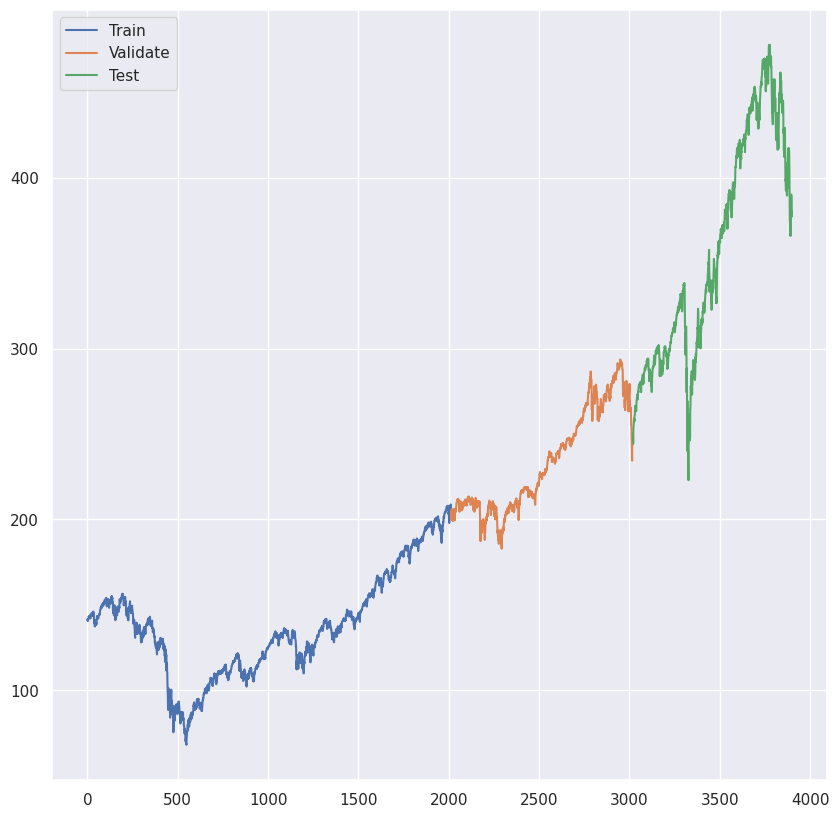

In [40]:
plt.plot(x_train, label="Train")
plt.plot(x_valid, label="Validate")
plt.plot(x_test, label="Test")
plt.legend()

### Normalisation

We normalize the data before the learning. The scalability is made with respect to the training dataset, so the values of valid and test datatests are on the same scale, which take away a bias. Here, as the price is increasing through time and we want to focus on predicting returns, normalisation is required.

In [41]:
x_train_scaler: MinMaxScaler
normalized_x_train: np.array
normalized_x_valid: np.array
normalized_x_test: np.array
spy_normalized_to_traindata: np.array

(
    x_train_scaler, normalized_x_train, normalized_x_valid, normalized_x_test,
    spy_normalized_to_traindata
 ) = normalization(x_train_values_=x_train.values.reshape(-1, 1),
                   x_test_values_=x_test.values.reshape(-1, 1),
                   x_valid_values_=x_valid.values.reshape(-1, 1),
                   origin_=series.values.reshape(-1, 1))

## CNN Model

CNN Models are more commonly used for Computer Vision purposes as the convolutional layers are responsible to capture the principal components of each part of an image and abstract them to carry enough information to be able to generalise. It is also widely used for generation of audio time-series, as it was the preliminary motivation of the design of WaveNet architecture. Since then, it has been transposed to time-series forecasting was we want to perform in this exercise.

In the litterature, learning rate for training a CNN with WaveNet architecture is at the scale of $10^{-4}$ and we choose a window size of $30$.

In [42]:
type_of_model: str = "cnn"
nb_variables: int = 1
model_training(type_=type_of_model, window_size_=window_size,
               learning_rate_=5e-4, nb_variables_=nb_variables)

Epoch 1/100


2023-04-24 17:37:10.840481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2014,1,1]
	 [[{{node Placeholder/_0}}]]
2023-04-24 17:37:10.840947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2014,1,1]
	 [[{{node Placeholder/_0}}]]


     13/Unknown - 5s 14ms/step - loss: 0.0779 - mae: 0.3504

2023-04-24 17:37:15.543446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1006,1,1]
	 [[{{node Placeholder/_0}}]]
2023-04-24 17:37:15.544296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1006,1,1]
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 5s 69ms/step - loss: 0.0690 - mae: 0.3210 - val_loss: 0.0711 - val_mae: 0.2735
Epoch 2/100
16/16 [==============================] - 1s 27ms/step - loss: 0.0068 - mae: 0.0872 - val_loss: 0.0192 - val_mae: 0.1543
Epoch 3/100
16/16 [==============================] - 0s 26ms/step - loss: 0.0016 - mae: 0.0437 - val_loss: 0.0039 - val_mae: 0.0744
Epoch 4/100
16/16 [==============================] - 1s 31ms/step - loss: 2.9966e-04 - mae: 0.0183 - val_loss: 5.7981e-04 - val_mae: 0.0242
Epoch 5/100
16/16 [==============================] - 1s 31ms/step - loss: 1.6810e-04 - mae: 0.0140 - val_loss: 3.6404e-04 - val_mae: 0.0192
Epoch 6/100
16/16 [==============================] - 1s 36ms/step - loss: 1.3812e-04 - mae: 0.0124 - val_loss: 3.3414e-04 - val_mae: 0.0198
Epoch 7/100
16/16 [==============================] - 1s 31ms/step - loss: 1.2649e-04 - mae: 0.0118 - val_loss: 2.6790e-04 - val_mae: 0.0164
Epoch 8/100
16/16 [==============================] - 0s 

In [43]:
# reload best model checkpoint
model: keras.models = keras.models.load_model(
    f"my_checkpoint_{type_of_model}_{nb_variables}.h5")

In [46]:
cnn_unscaled_forecast: np.array = format_cnn_forecast(
    model_=model, spy_normalized_to_traindata_=spy_normalized_to_traindata,
    x_test_ = x_test, x_train_scaler_=x_train_scaler, window_size_=window_size
    )

     46/Unknown - 0s 3ms/step

2023-04-24 17:58:36.664370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3901,1,1]
	 [[{{node Placeholder/_0}}]]
2023-04-24 17:58:36.665474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3901,1,1]
	 [[{{node Placeholder/_0}}]]


121/121 [==============================] - 0s 4ms/step


Visualisation of the prediction

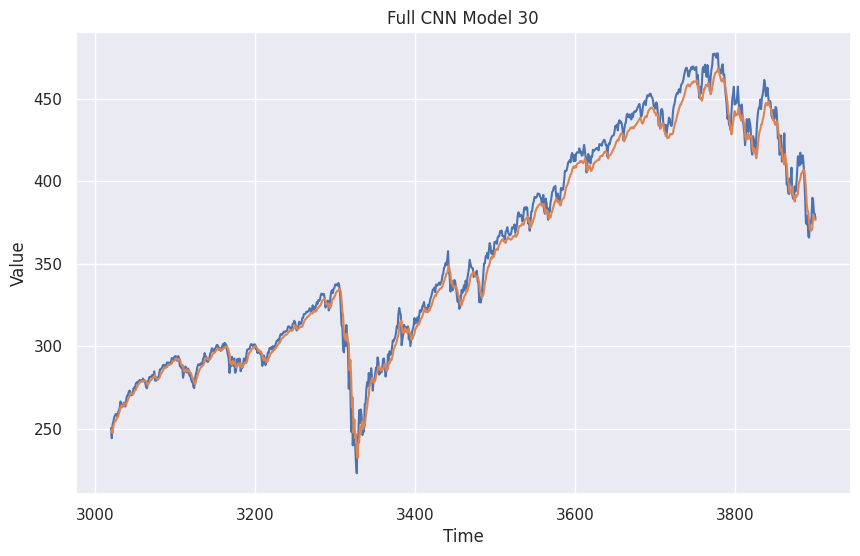

In [47]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plot_series(x_test.index, x_test)
plot_series(x_test.index, cnn_unscaled_forecast)

This visualisation shows a prediction of the price which is, on average, close to the evolution of the SPY price. Therefore, the curve of the prediction shows that the model fails to capture the day-by-day differences on the price and therefore is not satisfying enough for the prediction of the return. The average shape of the evolution of the price is well reproduced but there is a gap we do not want to have in the precision.

In [48]:
# Calculate MAE on price
keras.metrics.mean_absolute_error(x_test, cnn_unscaled_forecast).numpy()

5.6175246

In [49]:
# Calculate MAE on Return
x_test_series: pd.Series = (pd.Series(x_test) - pd.Series(x_test).shift(1)).dropna()
cnn_unscaled_forecast_series: pd.Series = (pd.Series(cnn_unscaled_forecast) - pd.Series(cnn_unscaled_forecast).shift(1)).dropna()
keras.metrics.mean_absolute_error(x_test_series, cnn_unscaled_forecast_series).numpy()

3.6328223

## LSTM Model

The LSTM (Long-Short Term Memory) Neural Network is a type of recurrent neural network which has been designed to be able to capture the temporal component of a dataset, which was not possible with classical Perceptron architecture. The LSTM cell, in comparison of the RNN cell, controls the values of the gradient of the loss function in the forward-backward propagation, so it avoids the phenomenon of vanishing or exploding gradient.

In the litterature, learning rate for training an LSTM Neural Network is at the scale of $10^{-4}$ and we choose a window size of $30$. We fine tune a higher number of epochs of $500$, compared to $100$ for CNN, with early stopping method of $50$ epochs as patience, in case the values of the loss function in the stochastic gradient descent does not reduce any more and is in stagnation.

The early stopping method is also a feature which prevents overfitting of a model. If the loss value stagnates, this is representative of the phenomenom of having the predicted solution in a local minimum of the hyperplane of solutions. The loss value therefore stagnate, as the weights values are still evolving through the epochs during the learning, but the local minimum is already reached.

In [50]:
type_of_model: str = "lstm"
nb_variables_: int = 1
model_training(
    type_=type_of_model, window_size_=window_size, learning_rate_=1e-4,
    nb_variables_=nb_variables_, nb_epochs_=500, patience_=50)

2023-04-24 17:58:38.332481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 17:58:38.334696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 17:58:38.336926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/500


2023-04-24 17:58:38.651060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 17:58:38.653114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 17:58:38.654950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

     65/Unknown - 6s 9ms/step - loss: 0.0269 - mae: 0.1616

2023-04-24 17:58:45.194405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1006,1]
	 [[{{node Placeholder/_0}}]]
2023-04-24 17:58:45.194869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1006,1]
	 [[{{node Placeholder/_0}}]]
2023-04-24 17:58:45.453750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

67/67 [==============================] - 7s 25ms/step - loss: 0.0261 - mae: 0.1578 - val_loss: 0.0016 - val_mae: 0.0436
Epoch 2/500
67/67 [==============================] - 1s 12ms/step - loss: 0.0012 - mae: 0.0329 - val_loss: 0.0018 - val_mae: 0.0463
Epoch 3/500
67/67 [==============================] - 1s 12ms/step - loss: 0.0011 - mae: 0.0319 - val_loss: 0.0020 - val_mae: 0.0480
Epoch 4/500
67/67 [==============================] - 1s 11ms/step - loss: 0.0011 - mae: 0.0315 - val_loss: 0.0021 - val_mae: 0.0498
Epoch 5/500
67/67 [==============================] - 1s 11ms/step - loss: 0.0011 - mae: 0.0311 - val_loss: 0.0023 - val_mae: 0.0513
Epoch 6/500
67/67 [==============================] - 1s 13ms/step - loss: 0.0010 - mae: 0.0307 - val_loss: 0.0024 - val_mae: 0.0524
Epoch 7/500
67/67 [==============================] - 1s 12ms/step - loss: 0.0010 - mae: 0.0304 - val_loss: 0.0025 - val_mae: 0.0534
Epoch 8/500
67/67 [==============================] - 1s 11ms/step - loss: 9.8691e-04 - m

In [51]:
# recall best model
model: keras.models = keras.models.load_model(
    f"my_checkpoint_{type_of_model}_{nb_variables_}.h5")

2023-04-24 17:59:25.740315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 17:59:25.742187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 17:59:25.743904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [52]:
rnn_unscaled_forecast: np.array = format_rnn_forecast(
    model_=model, normalized_x_test_=normalized_x_test,
    x_train_scaler_=x_train_scaler, window_size_=window_size
    )

2023-04-24 17:59:26.437036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 17:59:26.439031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 17:59:26.440691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 644ms/step


Visualisation of the prediction

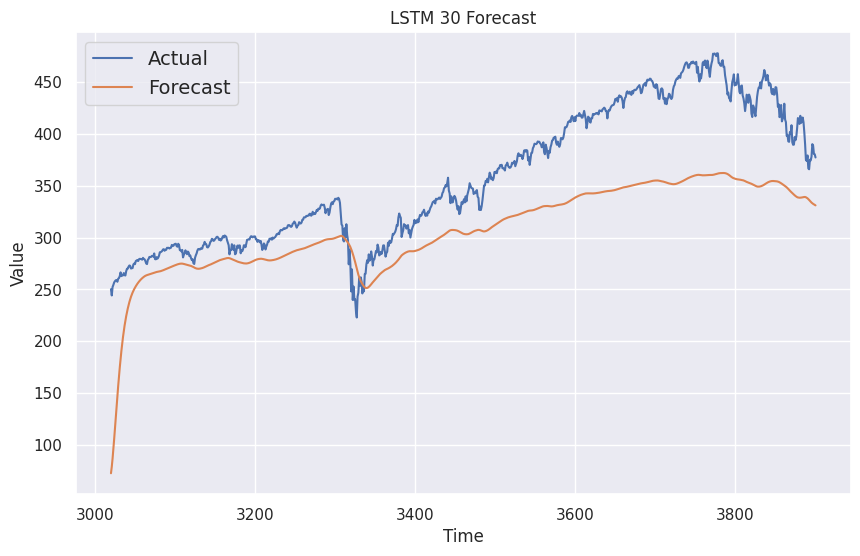

In [53]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

Here, the result is bad as it fails both to capture the day-by-day differences in the price and the shape of the curve is too different from the shape of the test set

In [54]:
# Calculate MAE on price
keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()

50.902527

In [55]:
# Calculate MAE on return
x_test_series: pd.Series = (pd.Series(x_test) - pd.Series(x_test).shift(1)).dropna()
rnn_unscaled_forecast_series: pd.Series = (pd.Series(rnn_unscaled_forecast) - pd.Series(rnn_unscaled_forecast).shift(1)).dropna()
keras.metrics.mean_absolute_error(x_test_series, rnn_unscaled_forecast_series).numpy()

3.2318673

We notice that the value of the mean absolute error of the prediction of the returns with LSTM Neural Network is similar than the error of the CNN prediction of those returns. The error is higher for the price, as the prediction is too far from the test dataset, but in both cases the returns are not capture, as both predictions are not precise enough.

To capture more precision on the predictions, we introduce feature engineering on the dataset and make predictions using other informations than the SPY closing price.

# Learning using VIX and SPY returns

## Features Engineering : construction of indicators

### Construction of Moving Average Convergence Divergence (MACD) indicator

This indicator is a momentum oscillator used to trade trends. It used to give trading signals, prioritizing the most current information in its weighting process thanks to exponential averages. Litterature defines those weighted averages with 26 days for the component dedicated to the market standard and 12 days as usual for the financial market. [4]

In [56]:
# Computation of 12 days EMA (Exponentially moving average)
data[c.EMA12] = data[c.SPY].ewm(span=12, adjust=False).mean()

# Computation of 26 days EMA
data[c.EMA26] = data[c.SPY].ewm(span=26, adjust=False).mean()

# Computation of MACD
data[c.MACD] = data[c.EMA12] - data[c.EMA26]

### Construction of Relative Strength Index (RSI) indicator

This indicator measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security. [5] It carries useful information as feature for a machine learning approach. [6]

In [57]:
mask_up_days: pd.Series = data[c.SPY] > data[c.SPY].shift(1)
mask_down_days: pd.Series = data[c.SPY] < data[c.SPY].shift(1)

# Computation of up and down days
data[c.UP_DAYS] = 0
data[c.DOWN_DAYS] = 0
data.loc[mask_up_days, c.UP_DAYS] = data[c.SPY] - data[c.SPY].shift(1)
data.loc[mask_down_days, c.DOWN_DAYS] = data[c.SPY].shift(1) - data[c.SPY]

# Computation of corresponding exponentialy-weighted average
data[c.EMA14_UP] = data[c.UP_DAYS].ewm(span=14, adjust=False).mean()
data[c.EMA14_DOWN] = data[c.DOWN_DAYS].ewm(span=14, adjust=False).mean()

# Computation of final indicator
data[c.RSI] = 100 * data[c.EMA14_UP]/(data[c.EMA14_UP]+data[c.EMA14_DOWN])

## Datasets

We add shifted values of indicators and index, as done in [2], to emphasize on the prediction of the return and the day-to-day differences for 1 and 2 days.

In [58]:
# Keep only variables for learning
X: pd.DataFrame = data[[c.DATE, c.SPY, c.VIX, c.RETURNS, c.MACD, c.RSI]]

# Create new variables based on values of previous days for VIX, MACD and RSI
X[c.VIX_1] = X[c.VIX].shift(1)
X[c.VIX_2] = X[c.VIX].shift(2)
X[c.MACD_1] = X[c.MACD].shift(1)
X[c.MACD_2] = X[c.MACD].shift(2)
X[c.RSI_1] = X[c.RSI].shift(1)
X[c.RSI_2] = X[c.RSI].shift(2)

# Clean NaN due to shifting by eliminating first values
mask_clean_dates: pd.Series = X[c.DATE] >= dt.date(2007, 1, 9)
X = X[mask_clean_dates].reset_index(drop=True)

In [59]:
# Create train, test and valid dataset
x_train: pd.DataFrame
x_test: pd.DataFrame
x_valid: pd.DataFrame
x_train, x_test, x_valid = create_train_test_valid_split(data=X)

### Normalisation

Here, this technique is useful as we introduce features of different natures, especially with different scales of values from a feature to an other. For example, the price and the return are not on the same scale, and higher numeric values introduce bias in the learning. This can be explained by the higher values being responsible for the weights of the neurons and making the impact of little values being negligible.

In [60]:
x_train_scaler: MinMaxScaler
normalized_x_train: np.array
normalized_x_valid: np.array
normalized_x_test: np.array
spy_normalized_to_traindata: np.array
(
    x_train_scaler, normalized_x_train, normalized_x_valid, normalized_x_test,
    spy_normalized_to_traindata
 ) = normalization(x_train_values_=x_train.values,
                   x_test_values_=x_test.values,
                   x_valid_values_=x_valid.values,
                   origin_=X.drop(columns=c.DATE).values)

## CNN Model

We conserve the same architecture to be able to compare with the first approach.

In [61]:
type_of_model: str = "cnn"
nb_variables: int = X.drop(columns=c.DATE).shape[1]
model_training(type_=type_of_model, window_size_=window_size, learning_rate_=5e-4, nb_variables_=nb_variables)

Epoch 1/100


2023-04-24 17:59:28.054811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2010,11,1]
	 [[{{node Placeholder/_0}}]]
2023-04-24 17:59:28.055117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2010,11,1]
	 [[{{node Placeholder/_0}}]]


     13/Unknown - 4s 13ms/step - loss: 0.0964 - mae: 0.3576

2023-04-24 17:59:32.602943: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.07GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-24 17:59:32.603520: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.07GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


     16/Unknown - 5s 54ms/step - loss: 0.0852 - mae: 0.3288

2023-04-24 17:59:32.958952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1006,11,1]
	 [[{{node Placeholder/_0}}]]
2023-04-24 17:59:32.960165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1006,11,1]
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 6s 103ms/step - loss: 0.0852 - mae: 0.3288 - val_loss: 0.0383 - val_mae: 0.2068
Epoch 2/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0129 - mae: 0.1176 - val_loss: 0.0217 - val_mae: 0.1425
Epoch 3/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0073 - mae: 0.0869 - val_loss: 0.0178 - val_mae: 0.1140
Epoch 4/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0049 - mae: 0.0714 - val_loss: 0.0144 - val_mae: 0.1019
Epoch 5/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0038 - mae: 0.0627 - val_loss: 0.0121 - val_mae: 0.0931
Epoch 6/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0031 - mae: 0.0571 - val_loss: 0.0094 - val_mae: 0.0859
Epoch 7/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0023 - mae: 0.0486 - val_loss: 0.0067 - val_mae: 0.0734
Epoch 8/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0021 - mae:

In [62]:
# reload best model checkpoint
model: keras.models = keras.models.load_model(f"my_checkpoint_{type_of_model}_{nb_variables}.h5")

In [63]:
# Retrieve output
cnn_unscaled_forecast: np.array = format_cnn_forecast(
    model_=model, spy_normalized_to_traindata_=spy_normalized_to_traindata,
    x_train_scaler_=x_train_scaler, window_size_=window_size,
    nb_variables_=nb_variables, x_test_=x_test)
cnn_unscaled_forecast.columns = X.drop(columns=c.DATE).columns

2023-04-24 17:59:58.087613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3897,11]
	 [[{{node Placeholder/_0}}]]
2023-04-24 17:59:58.087967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3897,11]
	 [[{{node Placeholder/_0}}]]


121/121 [==============================] - 1s 5ms/step


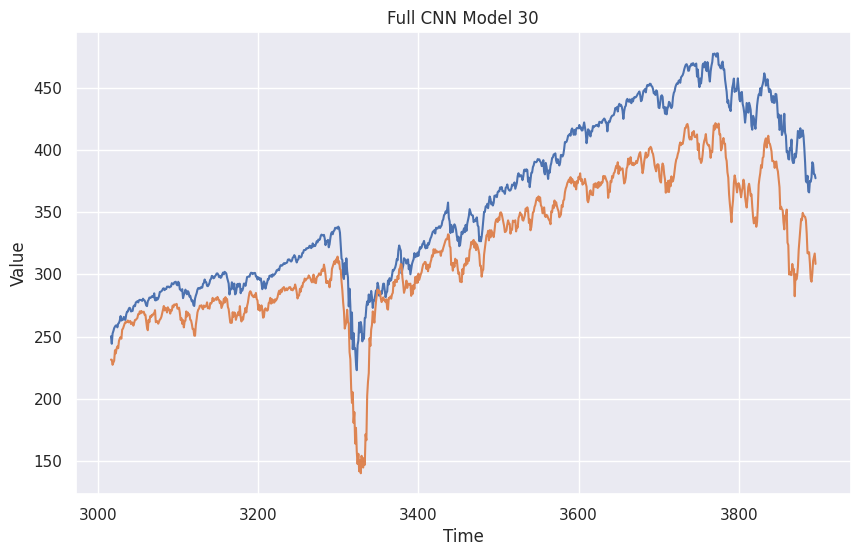

In [64]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plot_series(x_test.index, x_test[c.SPY])
plot_series(x_test.index, cnn_unscaled_forecast[c.SPY])

The visualisation of the price prediction has a spread regarding the real prediction and seems to be always below the real value. If we compare with the first approach, the introduction of new features in the dataset enables the model to capture the precision on the day-by-day differences in the price.

In [65]:
# Calculate MAE on price
keras.metrics.mean_absolute_error(x_test[c.SPY], cnn_unscaled_forecast[c.SPY]).numpy()

37.08724

In [66]:
# Calculate MAE on Returns
print(keras.metrics.mean_absolute_error(x_test[c.RETURNS], cnn_unscaled_forecast[c.RETURNS]).numpy())
print(keras.metrics.mean_absolute_error(x_test.loc[x_test.index.min()+1:, c.RETURNS], (cnn_unscaled_forecast[c.SPY] - cnn_unscaled_forecast[c.SPY].shift(1)).dropna()).numpy()) # drop first value which is NaN, due to the shift

6.470027
5.2437096


Even if the prediction is less accurate for the price compared to the previous approach, the mean absolute error on the return is also worse than previously, but not as worse as the price. As the model is able to capture more precision, it compensate the bias.

## LSTM Model

In [67]:
type_of_model: str = "lstm"
nb_variables: int = X.drop(columns=c.DATE).shape[1]
model_training(
    type_=type_of_model, window_size_=window_size, learning_rate_=5e-4,
    nb_variables_=nb_variables, nb_epochs_=500, patience_=50)

2023-04-24 18:00:00.132070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 18:00:00.134310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 18:00:00.135955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/500


2023-04-24 18:00:00.337383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 18:00:00.339868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 18:00:00.341293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

     66/Unknown - 5s 10ms/step - loss: 0.0226 - mae: 0.1331

2023-04-24 18:00:05.631349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1006,11]
	 [[{{node Placeholder/_0}}]]
2023-04-24 18:00:05.631596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1006,11]
	 [[{{node Placeholder/_0}}]]
2023-04-24 18:00:05.853181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

66/66 [==============================] - 6s 25ms/step - loss: 0.0226 - mae: 0.1331 - val_loss: 0.0090 - val_mae: 0.0882
Epoch 2/500
66/66 [==============================] - 1s 13ms/step - loss: 0.0070 - mae: 0.0825 - val_loss: 0.0082 - val_mae: 0.0831
Epoch 3/500
66/66 [==============================] - 1s 12ms/step - loss: 0.0059 - mae: 0.0747 - val_loss: 0.0077 - val_mae: 0.0794
Epoch 4/500
66/66 [==============================] - 1s 12ms/step - loss: 0.0050 - mae: 0.0686 - val_loss: 0.0075 - val_mae: 0.0773
Epoch 5/500
66/66 [==============================] - 1s 12ms/step - loss: 0.0046 - mae: 0.0655 - val_loss: 0.0074 - val_mae: 0.0760
Epoch 6/500
66/66 [==============================] - 1s 11ms/step - loss: 0.0042 - mae: 0.0630 - val_loss: 0.0074 - val_mae: 0.0751
Epoch 7/500
66/66 [==============================] - 1s 12ms/step - loss: 0.0039 - mae: 0.0606 - val_loss: 0.0074 - val_mae: 0.0743
Epoch 8/500
66/66 [==============================] - 1s 12ms/step - loss: 0.0037 - mae: 

In [68]:
# recall best model
model: keras.models = keras.models.load_model(
    f"my_checkpoint_{type_of_model}_{nb_variables}.h5")

2023-04-24 18:02:34.761107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 18:02:34.763131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 18:02:34.764942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [69]:
# Retrieve output
rnn_unscaled_forecast: pd.DataFrame = format_rnn_forecast(
    model_=model, normalized_x_test_=normalized_x_test,
    x_train_scaler_=x_train_scaler, window_size_=window_size,
    x_test_=x_test, nb_variables_=nb_variables)
rnn_unscaled_forecast.columns = X.drop(columns=c.DATE).columns

2023-04-24 18:02:35.527192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 18:02:35.529476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 18:02:35.531471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 716ms/step


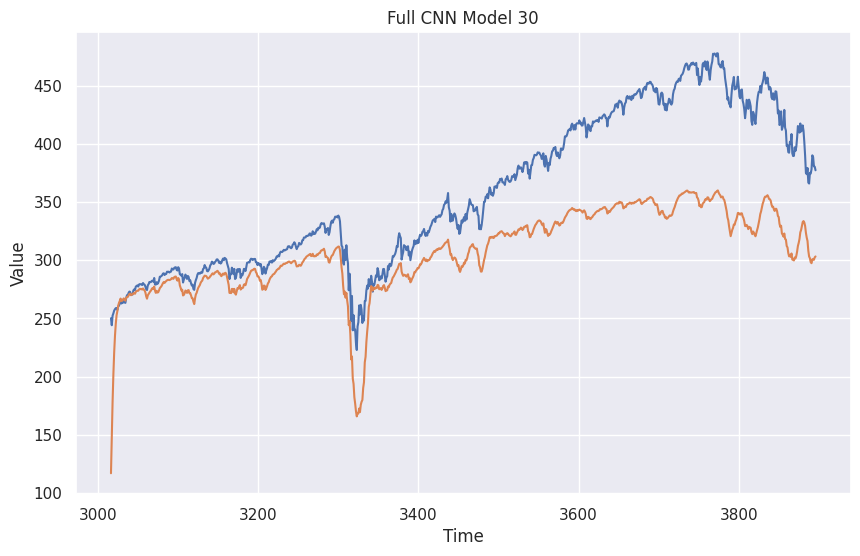

In [70]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plot_series(x_test.index, x_test[c.SPY])
plot_series(x_test.index, rnn_unscaled_forecast[c.SPY])

The shape of the prediction is similar than the prediction of price with LSTM in the first approach. The augmentation of the dataset was not able to solve the issue of the price prediction being to low compares to real values, especially when the horizon of days is too far away.

In [71]:
# Calculate MAE on price
keras.metrics.mean_absolute_error(x_test[c.SPY], rnn_unscaled_forecast[c.SPY]).numpy()

50.079678

In [72]:
# Calculate MAE on Returns
print(keras.metrics.mean_absolute_error(x_test[c.RETURNS], rnn_unscaled_forecast[c.RETURNS]).numpy())
print(keras.metrics.mean_absolute_error(x_test.loc[x_test.index.min()+1:, c.RETURNS], (rnn_unscaled_forecast[c.SPY] - rnn_unscaled_forecast[c.SPY].shift(1)).dropna()).numpy())

3.270152
2.2359679


This case is at the same time the worst prediction for the price, as the mean absolute error is the highest, but it is also the best prediction for the price, as the mean absolute error on the return is the lowest. The day-by-day precision is high enough to capture the variation of the price.

# Conclusion

A further investigation on this topic would be to fine-tune the models used by defining the hyper parameters more precisely for our dataset, using a grid search technique for example, and also a better definition of the architecture of the neural network. The scientific litterature does not present exact types of models responsible for the prediction of return values, but most of the models are based on classifiers to identify if the trading signals indicates either to buy or to sell. Other approaches tend to use machine learning algorithms for the calibration of financial time-series predictors, for example the calibration of geometric brownian motion, as done in this master's thesis [7]